In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns

DATADIR = r"./Brain-Tumor-Classification-DataSet-master/Training/"
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]

In [13]:
glimoa_train = os.listdir(DATADIR + "glioma_tumor")
men_train =  os.listdir(DATADIR + "meningioma_tumor")
notumor_train = os.listdir(DATADIR + "no_tumor")
pit_train =  os.listdir(DATADIR + "pituitary_tumor")

Text(0.5, 1.0, 'Type VS Number of Brain Tumour Images in Training Data')

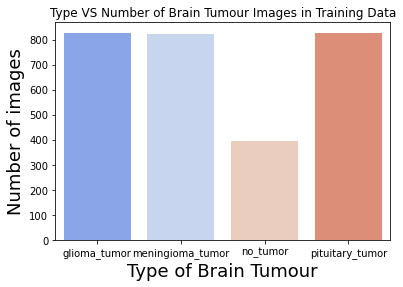

In [18]:

values = [len(glimoa_train), len(men_train), len(notumor_train), len(pit_train)]
sns.barplot(x = CATEGORIES, y = values, palette="coolwarm")
FS = 18
plt.xlabel('Type of Brain Tumour', fontsize=FS)
plt.ylabel('Number of images', fontsize=FS)
plt.title("Type VS Number of Brain Tumour Images in Training Data")


Data Manipulation

In [27]:
training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR,category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE)) 
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
create_training_data()

In [152]:
X = []
y = []

IMG_SIZE = 150

for features,label in training_data:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE)
print(X.shape)
X = X/255.0  
X = X.reshape(-1,150,150,1)

(2870, 150, 150)


In [153]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
y = to_categorical(y, num_classes = 4)

In [154]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)

x_train shape (2296, 150, 150, 1)
x_test shape (574, 150, 150, 1)
y_train shape (2296, 4)
y_test shape (574, 4)


CNN Prediction

In [36]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop ,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Activation

In [37]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=0,
        zoom_range = 0,
        width_shift_range=0,  
        height_shift_range=0,  
        horizontal_flip=True,  
        vertical_flip=False)

In [38]:
model1 =Sequential()
#4convolution layers and 2 maxpoollayer
model1.add(Conv2D(filters=32,kernel_size=5,input_shape=(150,150,1)))
model1.add(Activation('relu'))

model1.add(Conv2D(filters=32,kernel_size=4,input_shape=(150,150,1)))
model1.add(Activation('relu'))

model1.add(MaxPool2D(pool_size=3))

model1.add(Conv2D(filters=25,kernel_size=3,input_shape=(100,100,1)))
model1.add(Activation('relu'))

model1.add(Conv2D(filters=25,kernel_size=2,input_shape=(50,50,3)))
model1.add(Activation('relu'))

model1.add(MaxPool2D(pool_size=3))
#flatten layer
model1.add(Flatten())
#Deeeper hidden layer
model1.add(Dense(250))
model1.add(Activation('relu'))
#output layer
model1.add(Dense(4))
model1.add(Activation('sigmoid'))
model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
epochs= 10

In [39]:
from keras.callbacks import EarlyStopping

early_stop=EarlyStopping(monitor='val_loss',patience=3)

In [40]:
history1 = model1.fit(X_train,Y_train,epochs=5,validation_data=(X_val,Y_val),callbacks=[early_stop])

Epoch 1/5
72/72 [==============================] - 152s 2s/step - loss: 0.9678 - accuracy: 0.5858 - val_loss: 0.7650 - val_accuracy: 0.6916
Epoch 2/5
72/72 [==============================] - 145s 2s/step - loss: 0.6133 - accuracy: 0.7496 - val_loss: 0.6002 - val_accuracy: 0.7927
Epoch 3/5
72/72 [==============================] - 386s 5s/step - loss: 0.4462 - accuracy: 0.8306 - val_loss: 0.5613 - val_accuracy: 0.8118
Epoch 4/5
72/72 [==============================] - 141s 2s/step - loss: 0.3424 - accuracy: 0.8654 - val_loss: 0.5418 - val_accuracy: 0.8136
Epoch 5/5
72/72 [==============================] - 195s 3s/step - loss: 0.2167 - accuracy: 0.9177 - val_loss: 0.4736 - val_accuracy: 0.8554


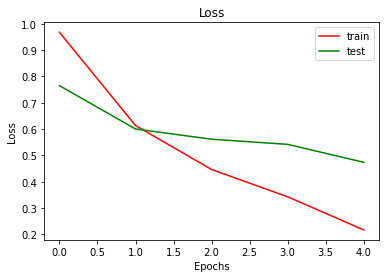

In [41]:
plt.plot(history1.history["loss"],c = "red")
plt.plot(history1.history["val_loss"],c = "green")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

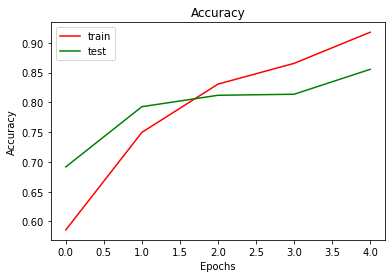

In [42]:
plt.plot(history1.history["accuracy"],c = "red")
plt.plot(history1.history["val_accuracy"],c = "green")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

In [43]:
model2 = Sequential()
#
model2.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (150,150,1)))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Dropout(0.25))
#
model2.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model2.add(Dropout(0.25))

model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model2.add(Dropout(0.3))
#
model2.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model2.add(Dropout(0.3))

#
model2.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model2.add(Dropout(0.3))
# 
model2.add(Flatten())
model2.add(Dense(1024, activation = "relu"))
model2.add(Dropout(0.5))
model2.add(Dense(4, activation = "softmax"))
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model2.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
epochs = 15  
batch_size = 40

C:\Users\yujia\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [44]:
datagen.fit(X_train)
history2 = model2.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              steps_per_epoch = X_train.shape[0] // batch_size) 

C:\Users\yujia\AppData\Local\Temp\ipykernel_20092\748267128.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model2.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),


Epoch 1/15
57/57 [==============================] - 239s 4s/step - loss: 1.3389 - accuracy: 0.3449 - val_loss: 1.1673 - val_accuracy: 0.5000
Epoch 2/15
57/57 [==============================] - 223s 4s/step - loss: 1.0159 - accuracy: 0.5634 - val_loss: 1.0056 - val_accuracy: 0.5488
Epoch 3/15
57/57 [==============================] - 193s 3s/step - loss: 0.8363 - accuracy: 0.6414 - val_loss: 0.8699 - val_accuracy: 0.6028
Epoch 4/15
57/57 [==============================] - 233s 4s/step - loss: 0.7818 - accuracy: 0.6622 - val_loss: 0.8503 - val_accuracy: 0.6063
Epoch 5/15
57/57 [==============================] - 239s 4s/step - loss: 0.6971 - accuracy: 0.7052 - val_loss: 0.7601 - val_accuracy: 0.6481
Epoch 6/15
57/57 [==============================] - 216s 4s/step - loss: 0.6228 - accuracy: 0.7398 - val_loss: 0.7756 - val_accuracy: 0.6376
Epoch 7/15
57/57 [==============================] - 213s 4s/step - loss: 0.5779 - accuracy: 0.7695 - val_loss: 0.7254 - val_accuracy: 0.6864
Epoch 8/15
57

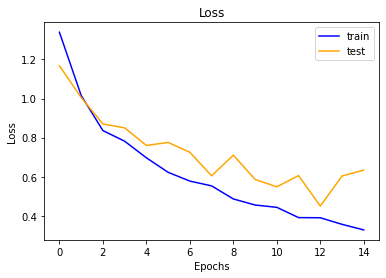

In [45]:
plt.plot(history2.history["loss"],c = "blue")
plt.plot(history2.history["val_loss"],c = "orange")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

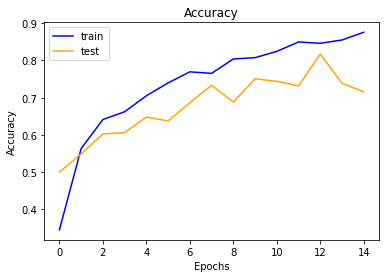

In [46]:
plt.plot(history2.history["accuracy"],c = "blue")
plt.plot(history2.history["val_accuracy"],c = "orange")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

In [47]:
model = Sequential()
# 5 conv. & 5 maxpool
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (150,150,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))
#
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

#
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

# 
model.add(Flatten())
model.add(Dense(1024, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation = "softmax"))
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
epochs = 50  
batch_size = 40

In [48]:
datagen.fit(X_train)
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              steps_per_epoch = X_train.shape[0] // batch_size)  

C:\Users\yujia\AppData\Local\Temp\ipykernel_20092\2585023828.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),


Epoch 1/50
57/57 [==============================] - 176s 3s/step - loss: 1.2981 - accuracy: 0.3648 - val_loss: 1.1749 - val_accuracy: 0.4164
Epoch 2/50
57/57 [==============================] - 228s 4s/step - loss: 0.9135 - accuracy: 0.6139 - val_loss: 0.9613 - val_accuracy: 0.5557
Epoch 3/50
57/57 [==============================] - 221s 4s/step - loss: 0.8368 - accuracy: 0.6432 - val_loss: 0.7708 - val_accuracy: 0.6481
Epoch 4/50
57/57 [==============================] - 712s 13s/step - loss: 0.7425 - accuracy: 0.6941 - val_loss: 0.7398 - val_accuracy: 0.6829
Epoch 5/50
57/57 [==============================] - 180s 3s/step - loss: 0.6908 - accuracy: 0.7048 - val_loss: 0.8045 - val_accuracy: 0.6272
Epoch 6/50
57/57 [==============================] - 178s 3s/step - loss: 0.6270 - accuracy: 0.7376 - val_loss: 0.6214 - val_accuracy: 0.7596
Epoch 7/50
57/57 [==============================] - 179s 3s/step - loss: 0.5535 - accuracy: 0.7571 - val_loss: 0.7262 - val_accuracy: 0.7108
Epoch 8/50
5

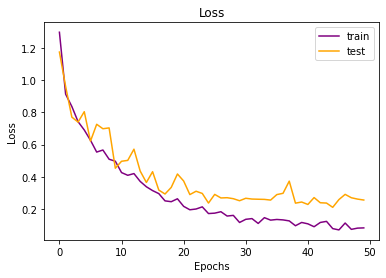

In [49]:
plt.plot(history.history["loss"],c = "purple")
plt.plot(history.history["val_loss"],c = "orange")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

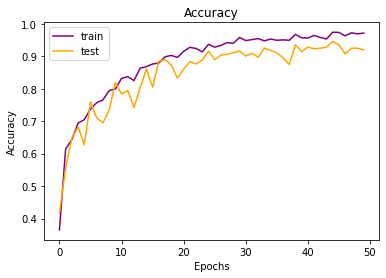

In [50]:
plt.plot(history.history["accuracy"],c = "purple")
plt.plot(history.history["val_accuracy"],c = "orange")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

18/18 [==============================] - 12s 687ms/step
Confusion Matrix


Text(70.8, 0.5, 'Predicted class')

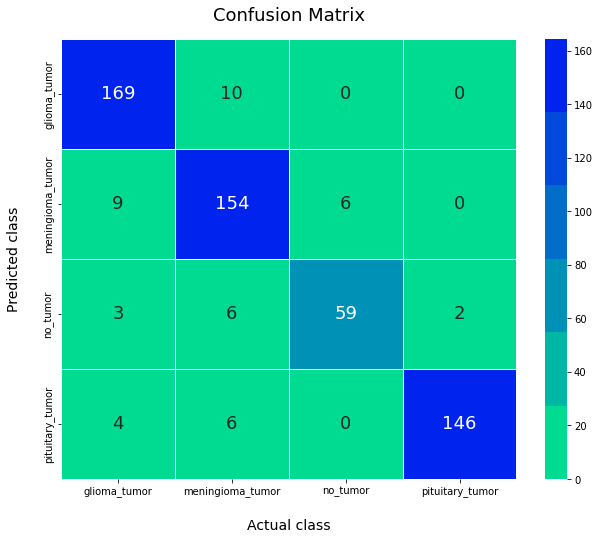

In [58]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report, confusion_matrix
import seaborn as sns

y_test_arg=np.argmax(Y_val,axis=1)
Y_pred = np.argmax(model.predict(X_val),axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_test_arg, Y_pred)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a=sns.color_palette("winter_r")  #_r inverts the palette
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)
#annot_kws: settings about annotations
ax.xaxis.set_ticklabels(CATEGORIES); ax.yaxis.set_ticklabels(CATEGORIES);
plt.yticks(va="center")
plt.title('Confusion Matrix',fontsize=18,pad=18)
plt.xlabel('Actual class',labelpad=22,fontsize=14)
plt.ylabel('Predicted class',labelpad=22,fontsize=14)

In [53]:
predict_x=model.predict(X_val) 
classes_x=np.argmax(predict_x,axis=1)
classes_x

18/18 [==============================] - 12s 678ms/step


array([0, 3, 0, 0, 3, 1, 3, 2, 0, 3, 1, 0, 1, 0, 3, 1, 1, 0, 2, 1, 0, 3,
       1, 3, 1, 0, 3, 1, 3, 0, 1, 2, 2, 0, 3, 1, 0, 2, 3, 0, 1, 3, 3, 3,
       2, 3, 3, 1, 1, 3, 1, 3, 1, 1, 0, 3, 0, 1, 2, 1, 1, 1, 0, 0, 0, 2,
       0, 0, 1, 1, 1, 3, 0, 1, 1, 0, 3, 3, 0, 0, 2, 0, 1, 2, 0, 1, 1, 3,
       2, 3, 2, 1, 2, 3, 0, 1, 0, 1, 3, 2, 3, 0, 2, 2, 1, 1, 3, 0, 3, 1,
       0, 0, 2, 3, 3, 1, 3, 3, 2, 0, 0, 3, 2, 3, 0, 2, 1, 1, 1, 0, 0, 0,
       2, 1, 3, 3, 2, 3, 1, 1, 1, 1, 3, 0, 1, 3, 2, 0, 1, 2, 1, 0, 0, 3,
       0, 2, 0, 2, 1, 0, 1, 0, 0, 2, 1, 1, 1, 1, 0, 1, 1, 3, 3, 3, 2, 0,
       0, 0, 3, 1, 1, 1, 2, 0, 0, 0, 3, 1, 3, 3, 2, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 0, 3, 1, 0, 3, 2, 1, 0, 0, 1, 3, 0,
       3, 0, 1, 0, 0, 3, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 3, 1, 1, 1, 3, 3,
       0, 0, 0, 0, 1, 1, 3, 3, 0, 1, 0, 1, 1, 0, 2, 2, 3, 3, 3, 3, 1, 3,
       1, 1, 1, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 3, 1, 1, 0, 3, 3, 0, 2, 3,
       2, 1, 0, 2, 1, 1, 3, 0, 1, 0, 2, 1, 3, 3, 3,

In [54]:
Y_val2 = np.argmax(Y_val,axis=1)
Y_val2

array([0, 3, 0, 0, 3, 1, 3, 2, 0, 3, 1, 1, 1, 0, 3, 0, 1, 0, 2, 1, 0, 3,
       1, 3, 1, 0, 3, 1, 3, 0, 1, 2, 2, 0, 3, 1, 0, 2, 3, 1, 1, 3, 3, 3,
       2, 3, 3, 1, 1, 3, 1, 3, 1, 1, 0, 3, 0, 1, 2, 1, 1, 1, 0, 0, 0, 2,
       1, 0, 1, 1, 1, 3, 0, 1, 1, 0, 3, 3, 0, 0, 2, 0, 1, 2, 0, 1, 1, 3,
       1, 3, 2, 1, 2, 3, 0, 1, 0, 1, 3, 2, 3, 0, 2, 2, 1, 1, 3, 0, 3, 1,
       0, 3, 2, 3, 3, 3, 3, 3, 2, 0, 0, 3, 2, 3, 0, 2, 1, 1, 0, 0, 0, 0,
       2, 1, 3, 3, 2, 3, 1, 1, 1, 1, 3, 0, 1, 3, 2, 0, 1, 2, 0, 2, 1, 3,
       0, 2, 0, 2, 1, 0, 1, 0, 0, 2, 1, 1, 1, 1, 0, 1, 1, 3, 3, 3, 2, 0,
       0, 0, 3, 1, 1, 1, 2, 0, 0, 0, 3, 1, 3, 3, 2, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 3, 3, 3, 2, 1, 1, 0, 1, 0, 3, 1, 0, 3, 2, 3, 2, 0, 2, 3, 0,
       3, 0, 1, 0, 0, 3, 0, 0, 0, 1, 0, 1, 0, 3, 0, 0, 3, 1, 1, 1, 3, 3,
       0, 0, 0, 0, 1, 1, 3, 3, 0, 1, 0, 1, 1, 0, 2, 2, 3, 3, 3, 3, 1, 3,
       1, 1, 1, 0, 3, 0, 1, 0, 0, 0, 0, 0, 3, 3, 1, 1, 0, 3, 3, 0, 2, 3,
       2, 1, 0, 2, 1, 1, 3, 0, 1, 0, 2, 1, 3, 3, 3,

In [55]:
model.save('kaggle_model_2.h5')

In [56]:
from sklearn.metrics import classification_report

In [59]:
print(classification_report(Y_val2,classes_x,target_names=CATEGORIES))

                  precision    recall  f1-score   support

    glioma_tumor       0.91      0.94      0.93       179
meningioma_tumor       0.88      0.91      0.89       169
        no_tumor       0.91      0.84      0.87        70
 pituitary_tumor       0.99      0.94      0.96       156

        accuracy                           0.92       574
       macro avg       0.92      0.91      0.91       574
    weighted avg       0.92      0.92      0.92       574

